In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [49]:
train_dir = 'data/Training//'
validation_dir = 'data/Testing//'

batch_size = 32
img_height = 256
img_width = 256

Grayscale images are best for MRI training because they show important details in shades of gray and make the model simpler. This matches how doctors view MRI scans, improving the model's accuracy and usefulness.

In [50]:
# Data augmentation and rescaling for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    
)

# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 5712 images belonging to 4 classes.


In [52]:
# Create validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', 
     color_mode='grayscale'
)

Found 1311 images belonging to 4 classes.


Display one image from each class 

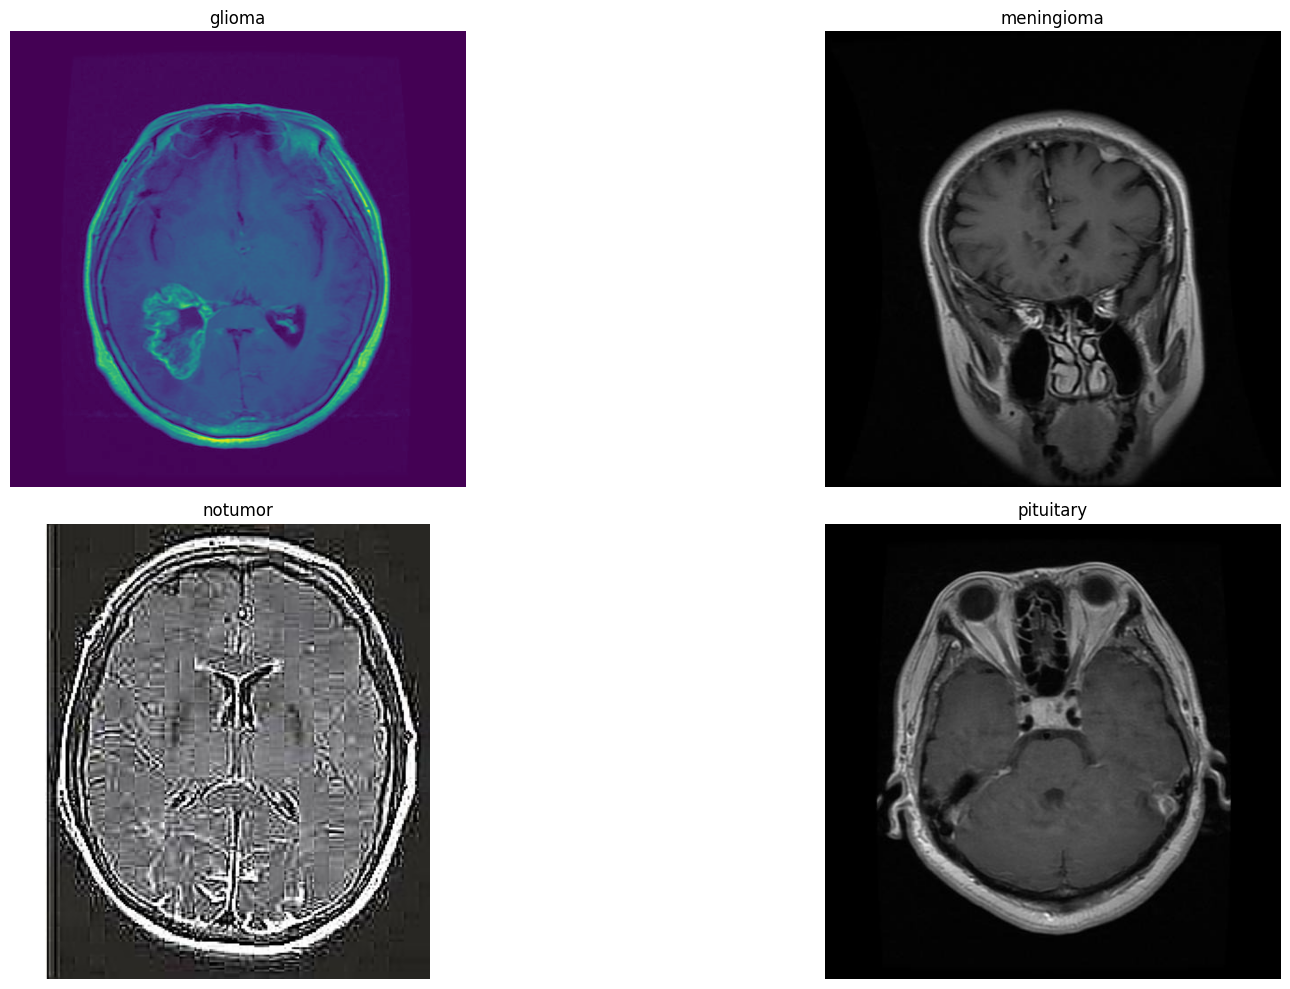

In [53]:
# Get the class names
class_names = list(train_generator.class_indices.keys())

# Determine the number of rows and columns
num_classes = len(class_names)
num_cols = (num_classes + 1) // 2  # Ensure we have at least two rows
num_rows = 2

# Create a figure to display images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate over class names to get one image from each category
for i, class_name in enumerate(class_names):
    row = i // num_cols
    col = i % num_cols
    
    # Path to the directory containing images of the current class
    class_dir = os.path.join(train_dir, class_name)
    
    # Get one image filename from the current class directory
    image_name = os.listdir(class_dir)[0]
    
    # Load the image
    image_path = os.path.join(class_dir, image_name)
    image = plt.imread(image_path)
    
    # Display the image
    ax = axes[row, col]
    ax.imshow(image)
    ax.set_title(class_name)
    ax.axis('off')

# Remove any empty subplots
for i in range(num_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### CNN Model

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same' , input_shape=(img_height, img_width, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu' ,  padding='same' ),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax') 
])

In [55]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,573,892 (128.07 MB)

 Trainable params: 33,573,892 (128.07 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples 
)

Epoch 1/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.6294 - loss: 0.9662 - val_accuracy: 0.7445 - val_loss: 0.7434
Epoch 2/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.7424 - loss: 0.6502 - val_accuracy: 0.7902 - val_loss: 0.5976
Epoch 3/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.7857 - loss: 0.5532 - val_accuracy: 0.7018 - val_loss: 0.8098
Epoch 4/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.7990 - loss: 0.5134 - val_accuracy: 0.7269 - val_loss: 0.8142
Epoch 5/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.8162 - loss: 0.4770 - val_accuracy: 0.7933 - val_loss: 0.6045
Epoch 6/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.8193 - loss: 0.4540 - val_accuracy: 0.7879 - val_loss: 0.5368
Epoch 7/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.8401 - loss: 0.4172 - val_accuracy: 0.8047 - val_loss: 0.5172
Epoch 8/20
5712/5712 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.8471 -

### The model achieves an accuracy of 91% on the training dataset and 88% on the validation dataset.